## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

## Properly store images 

When you're analyzing your image data, file management is important. We will be using the santa images again, but this time, they are stored in two folders: `normal` and `pneumonia`. We want to work with a `train`, `validation`, and `test` datasets now, as we know by now that this is the best way to obtain unbiased estimate of your model performance.  

Below we create three objects representing the existing directories: `data/PNEUMONIA` as `data_pneumonia_dir` and `data/NORMAL` as `data_normal_dir`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `PNEUMONIA` and `NORMAL` subfolders.

In [2]:
# Load the images; be sure to also preprocess these into tensors 
data_pneumonia_dir = 'data/PNEUMONIA/'
data_normal_dir = 'data/NORMAL/'
new_dir = 'split/'

Let's print out how many images we have in each directory so we know for sure our numbers are right!

In [3]:
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_pneumonia), ' PNEUMONIA images')

There are 4273  PNEUMONIA images


In [4]:
imgs_pneumonia[0:10]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg']

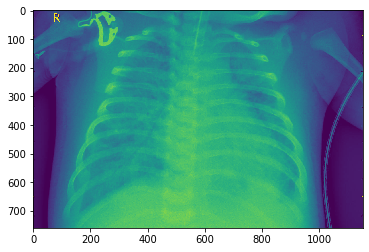

In [5]:
img = mpimg.imread(data_pneumonia_dir+imgs_pneumonia[0])
imgplot = plt.imshow(img)
plt.show()

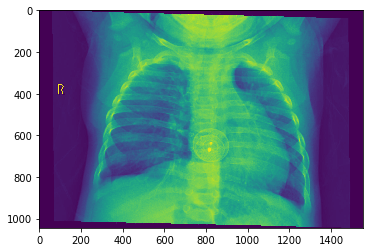

In [6]:
img = mpimg.imread(data_pneumonia_dir+imgs_pneumonia[10])
imgplot = plt.imshow(img)
plt.show()

In [7]:
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_normal), ' NORMAL images for training')

There are 1583  NORMAL images for training


In [8]:
imgs_normal[0:10]

['IM-0001-0001.jpeg',
 'IM-0003-0001.jpeg',
 'IM-0005-0001.jpeg',
 'IM-0006-0001.jpeg',
 'IM-0007-0001.jpeg',
 'IM-0009-0001.jpeg',
 'IM-0010-0001.jpeg',
 'IM-0011-0001-0001.jpeg',
 'IM-0011-0001-0002.jpeg',
 'IM-0011-0001.jpeg']

Create all the folders and subfolders in order to get the structure represented above. You can use `os.path.join()` to create strings that will be used later on to generate new directories.

In [9]:
if os.path.isdir(new_dir) == False:
    os.mkdir(new_dir)

In [10]:
train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [11]:
train_pneumonia

'split/train/PNEUMONIA'

Now use all the path strings you created to make new directories. You can use `os.mkdir()` to do this. Go have a look at your directory and see if this worked!

In [12]:
# testing folder
if os.path.isdir(test_folder) == False:
    os.mkdir(test_folder)
if os.path.isdir(test_pneumonia) == False:
    os.mkdir(test_pneumonia)
if os.path.isdir(test_normal) == False:
    os.mkdir(test_normal)

# training folder    
if os.path.isdir(train_folder) == False:
    os.mkdir(train_folder)
if os.path.isdir(train_pneumonia) == False:
    os.mkdir(train_pneumonia)
if os.path.isdir(train_normal) == False:
    os.mkdir(train_normal)

# validating folder
if os.path.isdir(val_folder) == False:
    os.mkdir(val_folder)
if os.path.isdir(val_pneumonia) == False:
    os.mkdir(val_pneumonia)
if os.path.isdir(val_normal) == False:  
    os.mkdir(val_normal)

Copy X-ray chest images in three subfolders. Let's put images in training, validation and testing sets, respectively.

* training

for the `PNEUMONIA` images!

In [13]:
# training data of pneumonia
imgs = imgs_pneumonia[:3418]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [14]:
# training data of normal
imgs = imgs_normal[:1267]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

* testing

for the `PNEUMONIA` images!

In [15]:
# testing data of pneumonia
imgs = imgs_pneumonia[3418:3845]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [16]:
# testing data of normal
imgs = imgs_normal[1267:1425]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(test_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

* validating

for the `PNEUMONIA` images!

In [17]:
# validating data of pneumonia
imgs = imgs_pneumonia[3845:4273]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [18]:
# validating data of normal
imgs = imgs_normal[1425:1583]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [19]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(150, 150), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [20]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(150, 150), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 792 images belonging to 2 classes.


In [21]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(150, 150), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 770 images belonging to 2 classes.


In [22]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

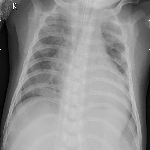

In [23]:
array_to_img(train_images[0])

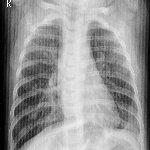

In [24]:
array_to_img(train_images[10])

In [25]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("*******************************************")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("*******************************************")
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("*******************************************")
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("*******************************************")

Number of training samples: 4685
Number of testing samples: 585
Number of validation samples: 585
*******************************************
train_images shape: (4685, 150, 150, 3)
train_labels shape: (4685, 2)
*******************************************
test_images shape: (585, 150, 150, 3)
test_labels shape: (585, 2)
*******************************************
val_images shape: (585, 150, 150, 3)
val_labels shape: (585, 2)
*******************************************


In [26]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4685, 67500)
(585, 67500)
(585, 67500)


In [27]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(4685, 2)
(585, 2)
(585, 2)


In [28]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [29]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [30]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4685, 1)
(585, 1)
(585, 1)


## Use a densely connected network as a baseline

Now that we've a handle on our data, we can easily use Keras' module with image-processing tools. Let's import the necessary libraries below. 

In [31]:
# Build a baseline fully connected model
baseline = models.Sequential()
baseline.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
baseline.add(layers.Dense(7, activation='relu'))
baseline.add(layers.Dense(5, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

In [32]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1350020   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [33]:
baseline.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
print('program starts, current time:')
print(start)
histoire = baseline.fit(train_img, train_y, epochs=40, batch_size=100, validation_data=(val_img, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-11-10 05:47:12.174761
Epoch 1/40
47/47 [==============================] - 2s 42ms/step - loss: 0.5744 - accuracy: 0.7264 - val_loss: 0.5460 - val_accuracy: 0.7128
Epoch 2/40
47/47 [==============================] - 2s 35ms/step - loss: 0.4931 - accuracy: 0.7296 - val_loss: 0.4781 - val_accuracy: 0.7128
Epoch 3/40
47/47 [==============================] - 2s 35ms/step - loss: 0.4521 - accuracy: 0.7701 - val_loss: 0.4283 - val_accuracy: 0.9009
Epoch 4/40
47/47 [==============================] - 2s 35ms/step - loss: 0.4133 - accuracy: 0.8213 - val_loss: 0.3566 - val_accuracy: 0.8838
Epoch 5/40
47/47 [==============================] - 2s 35ms/step - loss: 0.3667 - accuracy: 0.8566 - val_loss: 0.3519 - val_accuracy: 0.8462
Epoch 6/40
47/47 [==============================] - 2s 36ms/step - loss: 0.3568 - accuracy: 0.8572 - val_loss: 0.3898 - val_accuracy: 0.7128
Epoch 7/40
47/47 [==============================] - 2s 37ms/step - loss: 0.3364 - accuracy: 0.868

## Baseline Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [35]:
results_train_baseline = baseline.evaluate(train_img, train_y)

147/147 [==============================] - 1s 7ms/step - loss: 0.2028 - accuracy: 0.9338


In [36]:
results_test_baseline = baseline.evaluate(test_img, test_y)

19/19 [==============================] - 0s 6ms/step - loss: 0.1726 - accuracy: 0.9521


In [37]:
results_train_baseline

[0.2028243988752365, 0.9338313937187195]

In [38]:
results_test_baseline

[0.17257444560527802, 0.952136754989624]

In [39]:
histoire.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

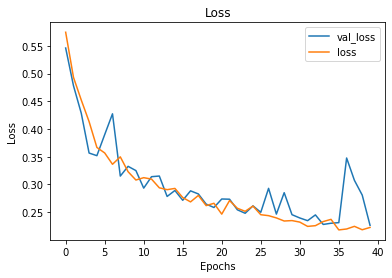

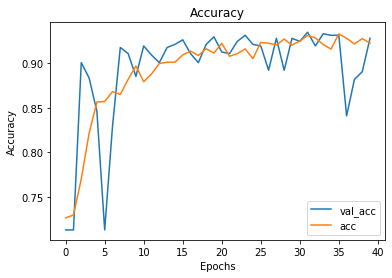

In [41]:
visualize_training_results(histoire)

## Saving baseline Model

Note: early stopping is introduced from Sep. 16th, 2020 (to avoid model training from over-fitting)
epoch number is changed from 100 down to 42

In [42]:
saved_baseline = baseline.save('baseline_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [43]:
preds_baseline = baseline.predict(test_img)

In [44]:
type(preds_baseline)

numpy.ndarray

In [45]:
preds_baseline.shape

(585, 1)

In [46]:
test_y.shape

(585, 1)

In [47]:
pred_baseline_class = baseline.predict_classes(test_img)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [48]:
pred_baseline_class.shape

(585, 1)

In [49]:
pred_baseline_binary_class = (baseline.predict(test_img) > 0.5).astype("int32")
pred_baseline_binary_class.shape

(585, 1)

In [50]:
# test set
true_classes_baseline = test_generator.classes
print(true_classes_baseline)
class_labels_baseline = list(test_generator.class_indices.keys())
class_labels_baseline

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [51]:
accuracy_baseline = accuracy_score(test_y, preds_baseline.round())
accuracy_baseline

0.9521367521367521

In [52]:
precision_baseline = precision_score(test_y, preds_baseline.round())
precision_baseline

0.9407894736842105

In [53]:
recall_baseline = recall_score(test_y, preds_baseline.round())
recall_baseline

0.8827160493827161

In [54]:
f1_baseline = f1_score(test_y, preds_baseline.round())
f1_baseline

0.910828025477707

In [55]:
auc_value_baseline = roc_auc_score(test_y, preds_baseline)
auc_value_baseline

0.988369378046289

In [56]:
fpr_baseline, tpr_baseline, threshold_baseline = roc_curve(test_y, preds_baseline)

In [57]:
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

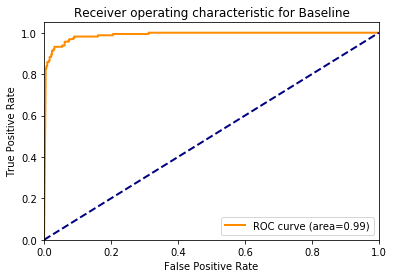

In [58]:
plt.figure()
lw=2
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_baseline)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Baseline')
plt.legend(loc='lower right')
plt.show()

In [59]:
report_baseline = classification_report(test_y, preds_baseline.round(), target_names=class_labels_baseline)
print(report_baseline)

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       423
   PNEUMONIA       0.94      0.88      0.91       162

    accuracy                           0.95       585
   macro avg       0.95      0.93      0.94       585
weighted avg       0.95      0.95      0.95       585



In [60]:
cnf_matrix_baseline = confusion_matrix(y_true=test_y, y_pred=preds_baseline.round())
np.set_printoptions(precision=2)
print(cnf_matrix_baseline)

[[414   9]
 [ 19 143]]


In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[414   9]
 [ 19 143]]


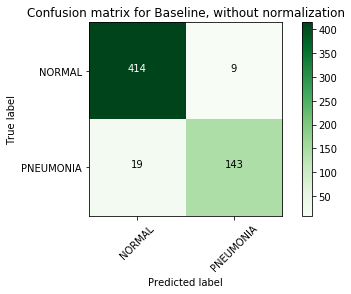

In [63]:
plt.figure()
plot_confusion_matrix(cnf_matrix_baseline, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.98 0.02]
 [0.12 0.88]]


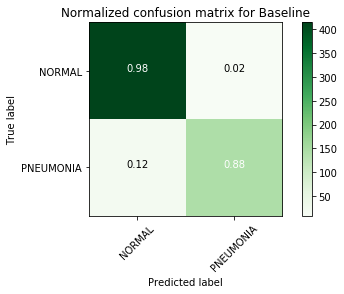

In [64]:
plt.figure()
plot_confusion_matrix(cnf_matrix_baseline, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving history in CSV

In [65]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(histoire.history) 
# or save to csv: 
hist_csv_file = 'baseline_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Designing CNN Model

Now it's time to design your CNN using Keras! Remember a few things when doing this: 

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base 
- Compile this model 

In [66]:
# Your code here; design and compile the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [67]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

## Training and Evaluating the Model

Remember that training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is apt to take hours to train on a high-end laptop. Using 30 epochs and 8 layers (alternating between convolutional and pooling), my model took about 14 hours to run on a 9 years old macbook pro (Late 2011, macOS High Sierra, v.10.13.6). That is, I set my model to run the training epochs overnight.  

In [68]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start2 = datetime.datetime.now()
print('program starts, current time:')
print(start2)
history = model.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
end2 = datetime.datetime.now()
print('program ends, current time:')
print(end2)
elapsed2 = end2 - start2
print('Training took a total of {}'.format(elapsed2))

program starts, current time:
2020-11-10 07:53:25.483154
Epoch 1/40
47/47 [==============================] - 379s 8s/step - loss: 0.5263 - accuracy: 0.7507 - val_loss: 0.3924 - val_accuracy: 0.8821
Epoch 2/40
47/47 [==============================] - 482s 10s/step - loss: 0.3411 - accuracy: 0.8625 - val_loss: 0.2705 - val_accuracy: 0.9094
Epoch 3/40
47/47 [==============================] - 523s 11s/step - loss: 0.2581 - accuracy: 0.8952 - val_loss: 0.2749 - val_accuracy: 0.8940
Epoch 4/40
47/47 [==============================] - 534s 11s/step - loss: 0.2185 - accuracy: 0.9116 - val_loss: 0.1883 - val_accuracy: 0.9402
Epoch 5/40
47/47 [==============================] - 508s 11s/step - loss: 0.1925 - accuracy: 0.9240 - val_loss: 0.1899 - val_accuracy: 0.9368
Epoch 6/40
47/47 [==============================] - 503s 11s/step - loss: 0.1788 - accuracy: 0.9276 - val_loss: 0.1941 - val_accuracy: 0.9316
Epoch 7/40
47/47 [==============================] - 506s 11s/step - loss: 0.1670 - accuracy:

## CNN Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [69]:
results_train = model.evaluate(train_images, train_y)

147/147 [==============================] - 78s 530ms/step - loss: 0.0321 - accuracy: 0.9883


In [70]:
results_test = model.evaluate(test_images, test_y)

19/19 [==============================] - 7s 369ms/step - loss: 0.0939 - accuracy: 0.9744


In [71]:
results_train

[0.03212900832295418, 0.9882603883743286]

In [72]:
results_test

[0.09392578154802322, 0.9743589758872986]

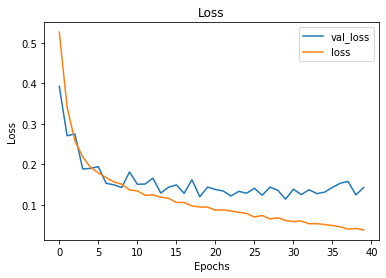

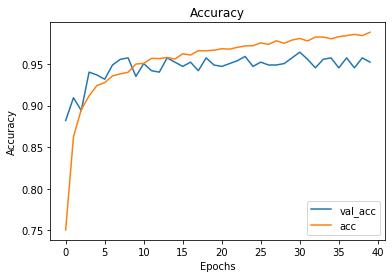

In [73]:
visualize_training_results(history)

## Saving CNN Model

In [74]:
# Your code here; save the model for future reference 
saved_cnn1 = model.save('cnn1_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [76]:
preds_cnn1 = model.predict(test_images)

In [77]:
type(preds_cnn1)

numpy.ndarray

In [78]:
preds_cnn1.shape

(585, 1)

In [79]:
test_y.shape

(585, 1)

In [80]:
pred_cnn1_class = model.predict_classes(test_images)

In [81]:
pred_cnn1_class.shape

(585, 1)

In [82]:
pred_cnn1_binary_class = (model.predict(test_images) > 0.5).astype("int32")
pred_cnn1_binary_class.shape

(585, 1)

In [83]:
# test set
true_classes_cnn1 = test_generator.classes
print(true_classes_cnn1)
class_labels_cnn1 = list(test_generator.class_indices.keys())
class_labels_cnn1

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [87]:
accuracy_cnn1 = accuracy_score(test_y, preds_cnn1.round())
accuracy_cnn1

0.9743589743589743

In [88]:
precision_cnn1 = precision_score(test_y, preds_cnn1.round())
precision_cnn1

0.9349112426035503

In [89]:
recall_cnn1 = recall_score(test_y, preds_cnn1.round())
recall_cnn1

0.9753086419753086

In [90]:
f1_cnn1 = f1_score(test_y, preds_cnn1.round())
f1_cnn1

0.9546827794561933

In [91]:
auc_value_cnn1 = roc_auc_score(test_y, preds_cnn1)
auc_value_cnn1

0.9954615766278493

In [92]:
fpr_cnn1, tpr_cnn1, threshold_cnn1 = roc_curve(test_y, preds_cnn1)

In [93]:
roc_auc_cnn1 = auc(fpr_cnn1, tpr_cnn1)

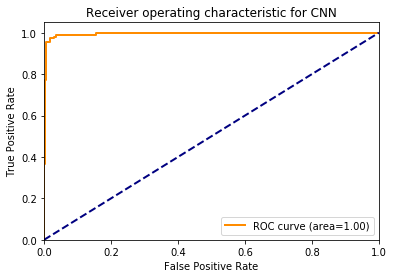

In [94]:
plt.figure()
lw=2
plt.plot(fpr_cnn1, tpr_cnn1, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_cnn1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN')
plt.legend(loc='lower right')
plt.show()

In [95]:
report_cnn1 = classification_report(test_y, preds_cnn1.round(), target_names=class_labels_cnn1)
print(report_cnn1)

              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98       423
   PNEUMONIA       0.93      0.98      0.95       162

    accuracy                           0.97       585
   macro avg       0.96      0.97      0.97       585
weighted avg       0.98      0.97      0.97       585



In [96]:
cnf_matrix_cnn1 = confusion_matrix(y_true=test_y, y_pred=preds_cnn1.round())
np.set_printoptions(precision=2)
print(cnf_matrix_cnn1)

[[412  11]
 [  4 158]]


Confusion matrix, without normalization
[[412  11]
 [  4 158]]


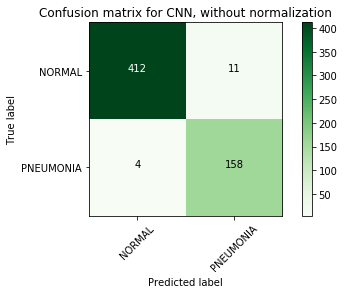

In [97]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn1, classes=cm_plot_labels, title='Confusion matrix for CNN, without normalization')
plt.show()

Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


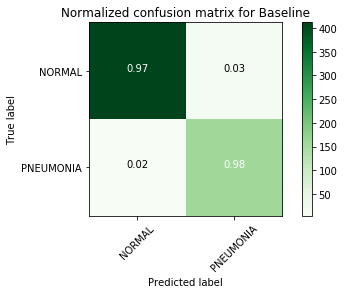

In [98]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn1, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving history in CSV

In [99]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Learning rate tuning 

In [103]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [104]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [105]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start3 = datetime.datetime.now()
print('program starts, current time:')
print(start3)
history2 = model2.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
end3 = datetime.datetime.now()
print('program ends, current time:')
print(end3)
elapsed3 = end3 - start3
print('Training took a total of {}'.format(elapsed3))

program starts, current time:
2020-11-11 05:39:21.546708
Epoch 1/40
47/47 [==============================] - 585s 12s/step - loss: 0.5925 - accuracy: 0.7247 - val_loss: 0.5784 - val_accuracy: 0.7128
Epoch 2/40
47/47 [==============================] - 583s 12s/step - loss: 0.5417 - accuracy: 0.7296 - val_loss: 0.5260 - val_accuracy: 0.7128
Epoch 3/40
47/47 [==============================] - 576s 12s/step - loss: 0.4761 - accuracy: 0.7507 - val_loss: 0.4625 - val_accuracy: 0.7282
Epoch 4/40
47/47 [==============================] - 573s 12s/step - loss: 0.4072 - accuracy: 0.8092 - val_loss: 0.4022 - val_accuracy: 0.8940
Epoch 5/40
47/47 [==============================] - 564s 12s/step - loss: 0.3517 - accuracy: 0.8615 - val_loss: 0.3411 - val_accuracy: 0.8598
Epoch 6/40
47/47 [==============================] - 601s 13s/step - loss: 0.3164 - accuracy: 0.8764 - val_loss: 0.3214 - val_accuracy: 0.8906
Epoch 7/40
47/47 [==============================] - 581s 12s/step - loss: 0.2861 - accuracy

In [106]:
results2_train = model2.evaluate(train_images, train_y)

147/147 [==============================] - 73s 495ms/step - loss: 0.1163 - accuracy: 0.9592


In [107]:
results2_test = model2.evaluate(test_images, test_y)

19/19 [==============================] - 7s 361ms/step - loss: 0.0746 - accuracy: 0.9744


In [108]:
results2_train

[0.1162620335817337, 0.9592316150665283]

In [109]:
results2_test

[0.07458766549825668, 0.9743589758872986]

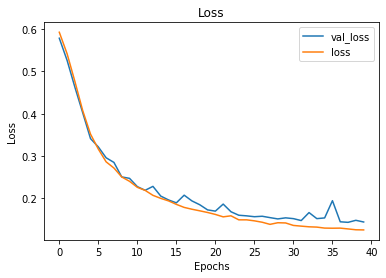

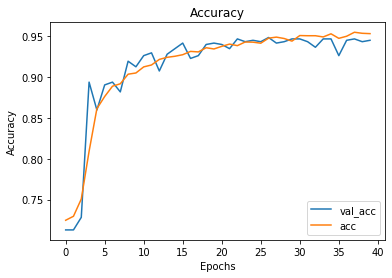

In [110]:
visualize_training_results(history2)

In [111]:
# Your code here; save the model for future reference 
model2.save('cnn1_chest_xray_ALL_data_LearningRate_Tuning_'+str(date.today())+'.h5')

In [112]:
preds_cnn2 = model2.predict(test_images)

In [113]:
type(preds_cnn2)

numpy.ndarray

In [114]:
preds_cnn2.shape

(585, 1)

In [115]:
pred_cnn2_class = model2.predict_classes(test_images)

In [116]:
pred_cnn2_class.shape

(585, 1)

In [117]:
pred_cnn2_binary_class = (model2.predict(test_images) > 0.5).astype("int32")
pred_cnn2_binary_class.shape

(585, 1)

In [118]:
# test set
true_classes_cnn2 = test_generator.classes
print(true_classes_cnn2)
class_labels_cnn2 = list(test_generator.class_indices.keys())
class_labels_cnn2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [119]:
accuracy_cnn2 = accuracy_score(test_y, preds_cnn2.round())
accuracy_cnn2

0.9743589743589743

In [120]:
precision_cnn2 = precision_score(test_y, preds_cnn2.round())
precision_cnn2

0.9349112426035503

In [121]:
recall_cnn2 = recall_score(test_y, preds_cnn2.round())
recall_cnn2

0.9753086419753086

In [122]:
f1_cnn2 = f1_score(test_y, preds_cnn2.round())
f1_cnn2

0.9546827794561933

In [123]:
auc_value_cnn2 = roc_auc_score(test_y, preds_cnn2)
auc_value_cnn2

0.996337156699647

In [124]:
fpr_cnn2, tpr_cnn2, threshold_cnn2 = roc_curve(test_y, preds_cnn2)

In [125]:
roc_auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)

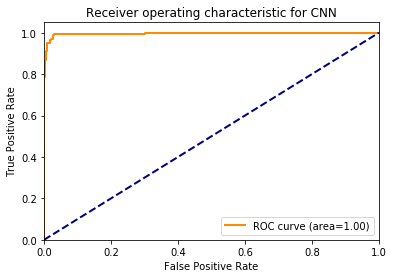

In [126]:
plt.figure()
lw=2
plt.plot(fpr_cnn2, tpr_cnn2, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_cnn2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN')
plt.legend(loc='lower right')
plt.show()

In [127]:
report_cnn2 = classification_report(test_y, preds_cnn2.round(), target_names=class_labels_cnn2)
print(report_cnn2)

              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98       423
   PNEUMONIA       0.93      0.98      0.95       162

    accuracy                           0.97       585
   macro avg       0.96      0.97      0.97       585
weighted avg       0.98      0.97      0.97       585



In [128]:
cnf_matrix_cnn2 = confusion_matrix(y_true=test_y, y_pred=preds_cnn2.round())
np.set_printoptions(precision=2)
print(cnf_matrix_cnn2)

[[412  11]
 [  4 158]]


Confusion matrix, without normalization
[[412  11]
 [  4 158]]


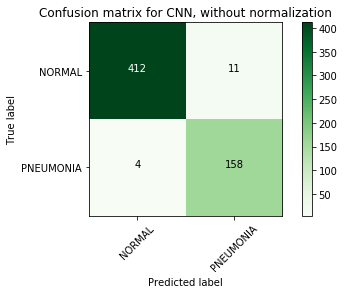

In [129]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn2, classes=cm_plot_labels, title='Confusion matrix for CNN, without normalization')
plt.show()

Normalized confusion matrix
[[0.97 0.03]
 [0.02 0.98]]


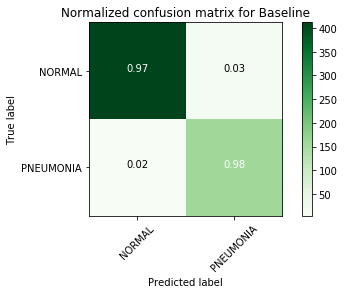

In [130]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn2, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

In [131]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data_LearningRate_Tuning'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Comparing Models

* accuracy history plot for densely connected network (baseline) and convolutional neural network 

In [ ]:
# CNN model details
cnn1_dict = history.history
cnn1_acc_values = cnn1_dict['accuracy'] 
cnn1_val_acc_values = cnn1_dict['val_accuracy']

# Baseline model
baseline_model_dict = histoire.history
baseline_model_acc = baseline_model_dict['accuracy'] 
baseline_model_val_acc = baseline_model_dict['val_accuracy']

# CNN model details (smaller learning rate, aka: LR)
cnn1_finerLR_dict = history3.history
cnn1_finerLR_acc_values = cnn1_finerLR_dict['accuracy'] 
cnn1_finerLR_val_acc_values = cnn1_finerLR_dict['val_accuracy']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_model_acc) + 1)
ax.plot(epochs, cnn1_acc_values, label='Training accuracy (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_val_acc_values, label='Validation accuracy (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_finerLR_acc_values, label='Training accuracy (CNN, LR=2e-5)')
ax.plot(epochs, cnn1_finerLR_val_acc_values, label='Validation accuracy (CNN, LR=2e-5)')
ax.plot(epochs, baseline_model_acc, label='Training accuracy (Baseline)')
ax.plot(epochs, baseline_model_val_acc, label='Validation accuracy (Baseline)')
ax.set_title('Training & validation accuracy CNN vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

* loss history plot for densely connected network (baseline) and convolutional neural network 

In [ ]:
# CNN model details
cnn1_dict = history.history
cnn1_loss_values = cnn1_dict['loss'] 
cnn1_val_loss_values = cnn1_dict['val_loss']

# Baseline model
baseline_model_dict = histoire.history
baseline_model_loss = baseline_model_dict['loss'] 
baseline_model_val_loss = baseline_model_dict['val_loss']

# CNN model details (smaller learning rate, aka: LR)
cnn1_finerLR_dict = history3.history
cnn1_finerLR_loss_values = cnn1_finerLR_dict['loss'] 
cnn1_finerLR_val_loss_values = cnn1_finerLR_dict['val_loss']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_model_loss) + 1)
ax.plot(epochs, cnn1_loss_values, label='Training loss (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_val_loss_values, label='Validation loss (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_finerLR_loss_values, label='Training accuracy (CNN, LR=2e-5)')
ax.plot(epochs, cnn1_finerLR_val_loss_values, label='Validation accuracy (CNN, LR=2e-5)')
ax.plot(epochs, baseline_model_loss, label='Training loss (Baseline)')
ax.plot(epochs, baseline_model_val_loss, label='Validation loss (Baseline)')
ax.set_title('Training & validation loss CNN vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

## Zooming images

In [132]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(210, 210), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [133]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 792 images belonging to 2 classes.


In [134]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 770 images belonging to 2 classes.


In [135]:
# create the data sets
train_images2, train_labels2 = next(train_generator2)
test_images2, test_labels2 = next(test_generator2)
val_images2, val_labels2 = next(val_generator2)

In [136]:
train_y2 = np.reshape(train_labels2[:,0], (train_labels2.shape[0],1))
test_y2 = np.reshape(test_labels2[:,0], (test_labels2.shape[0],1))
val_y2 = np.reshape(val_labels2[:,0], (val_labels2.shape[0],1))

In [137]:
# Your code here; design and compile the model
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(210, 210, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [138]:
model3.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [139]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start4 = datetime.datetime.now()
print('program starts, current time:')
print(start4)
history3 = model3.fit(train_images2, train_y2, epochs=40, batch_size=100, validation_data=(val_images2, val_y2))
end4 = datetime.datetime.now()
print('program ends, current time:')
print(end4)
elapsed4 = end4 - start4
print('Training took a total of {}'.format(elapsed4))

program starts, current time:
2020-11-11 23:06:00.548265
Epoch 1/40
47/47 [==============================] - 1493s 32s/step - loss: 0.5644 - accuracy: 0.7296 - val_loss: 0.5376 - val_accuracy: 0.7060
Epoch 2/40
47/47 [==============================] - 1250s 27s/step - loss: 0.4534 - accuracy: 0.7801 - val_loss: 0.4085 - val_accuracy: 0.8222
Epoch 3/40
47/47 [==============================] - 1154s 25s/step - loss: 0.3612 - accuracy: 0.8542 - val_loss: 0.3341 - val_accuracy: 0.8991
Epoch 4/40
47/47 [==============================] - 1167s 25s/step - loss: 0.2999 - accuracy: 0.8879 - val_loss: 0.2906 - val_accuracy: 0.8991
Epoch 5/40
47/47 [==============================] - 1133s 24s/step - loss: 0.2618 - accuracy: 0.9063 - val_loss: 0.2793 - val_accuracy: 0.9094
Epoch 6/40
47/47 [==============================] - 1107s 24s/step - loss: 0.2394 - accuracy: 0.9063 - val_loss: 0.2760 - val_accuracy: 0.8889
Epoch 7/40
47/47 [==============================] - 1136s 24s/step - loss: 0.2236 - a

In [140]:
results3_train = model3.evaluate(train_images2, train_y2)

147/147 [==============================] - 189s 1s/step - loss: 0.1243 - accuracy: 0.9552


In [141]:
results3_test = model3.evaluate(test_images2, test_y2)

19/19 [==============================] - 16s 848ms/step - loss: 0.0809 - accuracy: 0.9709


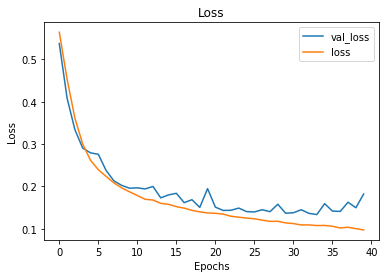

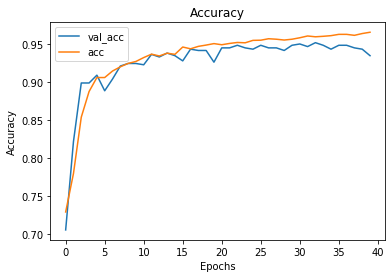

In [142]:
visualize_training_results(history3)

In [143]:
# Your code here; save the model for future reference 
model3.save('cnn1_bigger_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [144]:
preds_cnn3 = model3.predict(test_images2)

In [145]:
type(preds_cnn3)

numpy.ndarray

In [146]:
preds_cnn3.shape

(585, 1)

In [147]:
pred_cnn3_class = model3.predict_classes(test_images2)

In [148]:
pred_cnn3_class.shape

(585, 1)

In [149]:
pred_cnn3_binary_class = (model3.predict(test_images2) > 0.5).astype("int32")
pred_cnn3_binary_class.shape

(585, 1)

In [150]:
# test set
true_classes_cnn3 = test_generator2.classes
print(true_classes_cnn3)
class_labels_cnn3 = list(test_generator2.class_indices.keys())
class_labels_cnn3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [151]:
accuracy_cnn3 = accuracy_score(test_y2, preds_cnn3.round())
accuracy_cnn3

0.9709401709401709

In [152]:
precision_cnn3 = precision_score(test_y2, preds_cnn3.round())
precision_cnn3

0.9733333333333334

In [153]:
recall_cnn3 = recall_score(test_y2, preds_cnn3.round())
recall_cnn3

0.9182389937106918

In [154]:
f1_cnn3 = f1_score(test_y2, preds_cnn3.round())
f1_cnn3

0.9449838187702265

In [155]:
auc_value_cnn3 = roc_auc_score(test_y2, preds_cnn3)
auc_value_cnn3

0.9960433460300587

In [156]:
fpr_cnn3, tpr_cnn3, threshold_cnn3 = roc_curve(test_y2, preds_cnn3)

In [157]:
roc_auc_cnn3 = auc(fpr_cnn3, tpr_cnn3)

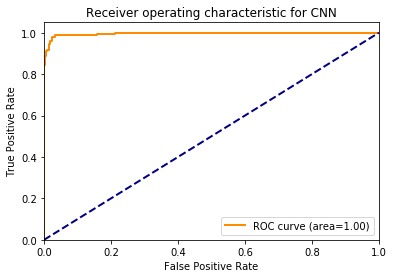

In [158]:
plt.figure()
lw=2
plt.plot(fpr_cnn3, tpr_cnn3, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_cnn3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN')
plt.legend(loc='lower right')
plt.show()

In [159]:
report_cnn3 = classification_report(test_y2, preds_cnn3.round(), target_names=class_labels_cnn3)
print(report_cnn3)

              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       426
   PNEUMONIA       0.97      0.92      0.94       159

    accuracy                           0.97       585
   macro avg       0.97      0.95      0.96       585
weighted avg       0.97      0.97      0.97       585



In [160]:
cnf_matrix_cnn3 = confusion_matrix(y_true=test_y2, y_pred=preds_cnn3.round())
np.set_printoptions(precision=2)
print(cnf_matrix_cnn3)

[[422   4]
 [ 13 146]]


Confusion matrix, without normalization
[[422   4]
 [ 13 146]]


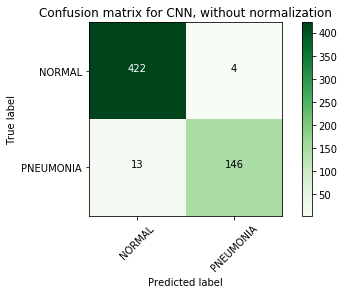

In [161]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn3, classes=cm_plot_labels, title='Confusion matrix for CNN, without normalization')
plt.show()

Normalized confusion matrix
[[0.99 0.01]
 [0.08 0.92]]


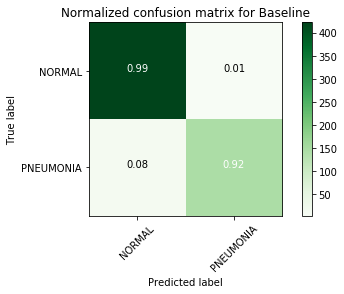

In [162]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn3, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

In [163]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 
# or save to csv: 
hist_csv_file = 'cnn1_bigger_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# CNN model details
cnn1_dict = history3.history
cnn1_acc_values = cnn1_dict['accuracy'] 
cnn1_val_acc_values = cnn1_dict['val_accuracy']

# Baseline model
cnn1_bigger_dict = history2.history
cnn1_bigger_acc = cnn1_bigger_dict['accuracy'] 
cnn1_bigger_val_acc = cnn1_bigger_dict['val_accuracy']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(cnn1_acc_values) + 1)
ax.plot(epochs, cnn1_acc_values, label='Training accuracy (CNN, 150x150)')
ax.plot(epochs, cnn1_val_acc_values, label='Validation accuracy (CNN, 150x150)')
ax.plot(epochs, cnn1_bigger_acc, label='Training accuracy (CNN, 210x210)')
ax.plot(epochs, cnn1_bigger_val_acc, label='Validation accuracy (CNN, 210x210)')
ax.set_title('Training & validation accuracy 150x150 vs 180x180 in CNN')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

In [ ]:
# CNN model details
cnn1_dict = history3.history
cnn1_loss_values = cnn1_dict['loss'] 
cnn1_val_loss_values = cnn1_dict['val_loss']

# Baseline model
cnn1_bigger_dict = history2.history
cnn1_bigger_loss = cnn1_bigger_dict['loss'] 
cnn1_bigger_val_loss = cnn1_bigger_dict['val_loss']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(cnn1_loss_values) + 1)
ax.plot(epochs, cnn1_loss_values, label='Training loss (CNN, 150x150)')
ax.plot(epochs, cnn1_val_loss_values, label='Validation loss (CNN, 150x150)')
ax.plot(epochs, cnn1_bigger_loss, label='Training loss (CNN, 210x210)')
ax.plot(epochs, cnn1_bigger_val_loss, label='Validation loss (CNN, 210x210)')
ax.set_title('Training & validation loss 150x150 vs 180x180 in CNN')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();